In [1]:
pip install cufinufft==2.4.0b1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 MB 3.7 MB/s eta 0:00:00


In [2]:
import torch
import cupy as cp
import cufinufft
import numpy as np


In [3]:
device = torch.device("cuda:0")
torch.set_default_dtype(torch.float64)

# 1- Sobolev regression

## 1.1 Package

In [4]:
def conjugate_gradient(A_function, b, x0, tol=1e-10, display=True):
    """
    Solves Ax = b using the Conjugate Gradient method.

    Parameters:
        A : function or matrix
            Matrix or function that computes the product Ax.
        b : ndarray
            Right-hand side vector.
        x0 : ndarray
            Initial guess.
        tol : float
            Tolerance for the stopping criterion.
        max_iter : int
            Maximum number of iterations.

    Returns:
        x : ndarray
            Approximate solution to Ax = b.
    """
    m = b.shape[0]

    x = x0
    r = b - A_function(x)
    p = r.clone()
    rs_old = torch.linalg.vector_norm(r)**2

    for i in range(3*m-2):#A cause de l'embedding pour avoir un circulant: on inverse Cx qui est de taille 3m
        Ap = A_function(p)
        alpha = rs_old / torch.vdot(p, Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        rs_new = torch.linalg.vector_norm(r)**2

        if torch.sqrt(rs_new) < tol:
          if display:
            print(f"CG converged in {i} iterations.")
          break
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new

    return x

In [5]:
def circulant_col(toeplitz_col, device):

  n = toeplitz_col.shape[0]

  # Create Hermitian-symmetric circulant embedding

  circulant_vector = torch.concatenate([
      toeplitz_col,
      torch.zeros(n-1, device=device),
      torch.conj(torch.flip(toeplitz_col[1:], (0,)))
  ])
  return circulant_vector, n

def fast_hermitian_toeplitz_mv(circulant, n, x, device):
    # Zero-pad x
    x_padded = torch.concatenate([x, torch.zeros(2 * n-2 , device=device)])

    # FFT-based convolution (complex)
    fft_c = torch.fft.fft(circulant)
    fft_x = torch.fft.fft(x_padded)

    y = torch.fft.ifft(fft_c * fft_x)[:n]

    return y  # complex-valued result

In [6]:
def kernel_vect(x_gpu, N, threshold):
  n = x_gpu.shape[0]
  y_gpu = cp.ones(n).astype(cp.complex128)

  f_gpu = cufinufft.nufft1d1(x_gpu, y_gpu, (2*N,), eps=threshold)[N:]/n
  f_tensor = torch.utils.dlpack.from_dlpack(f_gpu)

  circulant, n = circulant_col(f_tensor, device)
  return circulant

In [7]:
def S_vect_inv(m, s):
  frequencies =  torch.arange(-m, m+1, device=device)
  return 1/(1 + torch.abs(frequencies)**s)

def A_function(x, lambda_n, S_inv, k_circ):
  n = x.shape[0]
  kernel_term = S_inv* fast_hermitian_toeplitz_mv(k_circ, n, S_inv * x, device)
  return kernel_term + lambda_n * x

In [8]:
def NUFFT_Y(x_gpu, y_gpu, m, threshold):
  n = x_gpu.shape[0]

  f_gpu = cufinufft.nufft1d1(x_gpu, y_gpu, (2*m+1,), eps=threshold)/n

  f_tensor = torch.utils.dlpack.from_dlpack(f_gpu)

  return f_tensor

In [9]:
def FFT_inv(x_gpu, nufft, m, s, lambda_n, threshold, display=True):
    k_vect = kernel_vect(x_gpu, 2*m+1, threshold)
    S_inv = S_vect_inv(m, s)
    A_funct = lambda x: A_function(x, lambda_n, S_inv, k_vect)

    x0 = nufft.clone()
    inv = conjugate_gradient(A_funct, nufft, x0, tol=threshold, display=display)
    if display:
      print("Error CG ", torch.linalg.norm(A_funct(inv) - nufft))
    return S_inv * inv

In [10]:
def NUFFT_inv(x_gpu, f_gpu, N, threshold):
  n = x_gpu.shape[0]

  y_estimated = cufinufft.nufft1d2(x_gpu, f_gpu, eps=threshold)

  y_estimated = torch.utils.dlpack.from_dlpack(y_estimated)

  return y_estimated

## 1.2 Experiment

In [32]:
import time
np.random.seed(42)
cp.random.seed(seed=1)
torch.manual_seed(1)

n_tries = 20
s,d = 1,1
threshold = 10**-7

for experiment in range(n_tries):
  print("Experiment = ", experiment)
  err_N, list_N, time_N = np.array([]), np.array([]), np.array([])

  for i in range(1, 17):
    N = int(10**(i/2))
    x_gpu =  cp.random.uniform(size=N).astype(cp.float64)
    y_gpu =  cp.exp(x_gpu).astype(cp.complex128) + cp.random.normal(size=N).astype(cp.complex128)

    lambda_n=N**(-(2*s)/(2*s+d))
    m = int(N**(1/(2*s+d))) #int(np.sqrt(N))

    torch.cuda.synchronize()
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()

    S_inv = S_vect_inv(m, s)

    cov_y = S_inv*NUFFT_Y(x_gpu, y_gpu, m, threshold)
    hat_theta = FFT_inv(x_gpu, cov_y, m, s, lambda_n, threshold, display=False)

    end_event.record()
    torch.cuda.synchronize()
    time_N = np.append(time_N,start_event.elapsed_time(end_event)/10**3)

    N_test = 10**4
    x_test = cp.random.uniform(size=N_test).astype(cp.float64)
    y_test = cp.exp(x_test).astype(cp.complex128)

    estimator = torch.real(NUFFT_inv(x_test, hat_theta, m, threshold))

    error = torch.real(estimator.cpu()) - torch.tensor(y_test.get(), dtype=torch.float64)
    mse = torch.mean(torch.square(torch.abs(error)))

    list_N = np.append(list_N, N)
    err_N = np.append(err_N, mse)

  if experiment == 0:
    err_N_mean = err_N/n_tries
    time_N_mean = time_N/n_tries
  else:
    err_N_mean += err_N/n_tries
    time_N_mean += time_N/n_tries


Experiment =  0
Experiment =  1
Experiment =  2
Experiment =  3
Experiment =  4
Experiment =  5
Experiment =  6
Experiment =  7
Experiment =  8
Experiment =  9
Experiment =  10
Experiment =  11
Experiment =  12
Experiment =  13
Experiment =  14
Experiment =  15
Experiment =  16
Experiment =  17
Experiment =  18
Experiment =  19


Text(0, 0.5, 'MSE')

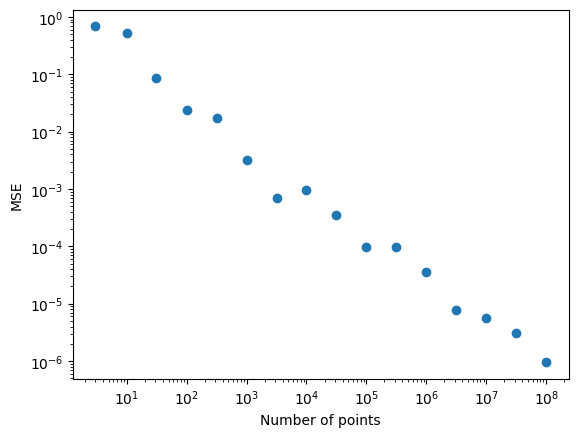

In [33]:
import matplotlib.pyplot as plt

plt.scatter(list_N, err_N)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of points")
plt.ylabel("MSE")

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


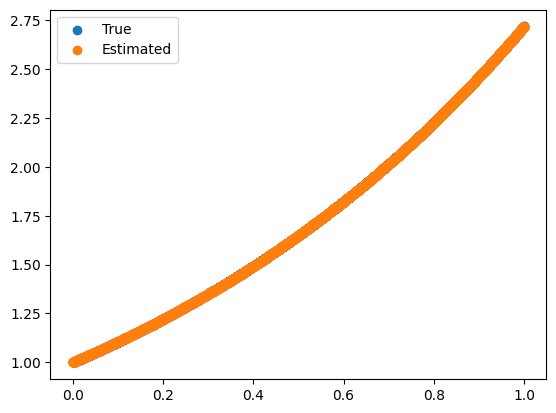

In [34]:
import matplotlib.pyplot as plt

plt.scatter(x_test.get(), y_test.get(), label="True")
plt.scatter(x_test.get(), estimator.cpu().numpy(), label="Estimated")
plt.legend()
plt.show()

## 1.3 High values of n

In [35]:
def FFT_inv_k(k_vect, nufft, m, s, lambda_n, threshold):
    S_inv = S_vect_inv(m, s)
    A_funct = lambda x: A_function(x, lambda_n, S_inv, k_vect)

    x0 = nufft.clone()
    inv = conjugate_gradient(A_funct, nufft, x0, tol=threshold)
    print("Error CG ", torch.linalg.norm(A_funct(inv) - nufft))
    return S_inv * inv

In [36]:
N_batch = 10**8

for iterations in [3, 10, 30, 100]:
  N_tot = N_batch*iterations

  threshold = 10e-15
  s,d = 1,1
  lambda_n=N_tot**(-(2*s)/(2*s+d))
  m = int(N_tot**(1/(2*s+d)))

  cov_y = torch.zeros(2*m+1, device=device)*(1.+0*1j)

  for i in range(iterations):

    x_gpu =  cp.random.uniform(size=N_batch).astype(cp.float64)
    y_gpu =  cp.exp(x_gpu).astype(cp.complex128) + cp.random.normal(size=N_batch).astype(cp.complex128)

    S_inv = S_vect_inv(m, s)

    cov_y += S_inv*NUFFT_Y(x_gpu, y_gpu, m, threshold)

    if i==0:
      k_vect = kernel_vect(x_gpu, 2*m+1, threshold)
    else:
      k_vect += kernel_vect(x_gpu, 2*m+1, threshold)

    print("Batch ", i, "/", iterations)

  cov_y /= iterations
  k_vect /= iterations

  hat_theta = FFT_inv_k(k_vect, cov_y, m, s, lambda_n, threshold)

  # Test
  N_test = 10**4
  x_test = cp.random.uniform(size=N_test).astype(cp.float64)
  y_test = cp.exp(x_test).astype(cp.complex128)

  estimator = torch.real(NUFFT_inv(x_test, hat_theta, m, threshold))

  error = torch.real(estimator.cpu()) - torch.tensor(y_test.get(), dtype=torch.float64)
  mse = torch.mean(torch.square(torch.abs(error)))

  list_N = np.append(list_N, N_tot)
  err_N = np.append(err_N, mse)


Batch  0 / 3
Batch  1 / 3
Batch  2 / 3
CG converged in 481 iterations.
Error CG  tensor(5.9167e-15, device='cuda:0')
Batch  0 / 10
Batch  1 / 10
Batch  2 / 10
Batch  3 / 10
Batch  4 / 10
Batch  5 / 10
Batch  6 / 10
Batch  7 / 10
Batch  8 / 10
Batch  9 / 10
CG converged in 669 iterations.
Error CG  tensor(8.4424e-15, device='cuda:0')
Batch  0 / 30
Batch  1 / 30
Batch  2 / 30
Batch  3 / 30
Batch  4 / 30
Batch  5 / 30
Batch  6 / 30
Batch  7 / 30
Batch  8 / 30
Batch  9 / 30
Batch  10 / 30
Batch  11 / 30
Batch  12 / 30
Batch  13 / 30
Batch  14 / 30
Batch  15 / 30
Batch  16 / 30
Batch  17 / 30
Batch  18 / 30
Batch  19 / 30
Batch  20 / 30
Batch  21 / 30
Batch  22 / 30
Batch  23 / 30
Batch  24 / 30
Batch  25 / 30
Batch  26 / 30
Batch  27 / 30
Batch  28 / 30
Batch  29 / 30
CG converged in 960 iterations.
Error CG  tensor(8.6314e-15, device='cuda:0')
Batch  0 / 100
Batch  1 / 100
Batch  2 / 100
Batch  3 / 100
Batch  4 / 100
Batch  5 / 100
Batch  6 / 100
Batch  7 / 100
Batch  8 / 100
Batch  9 / 1

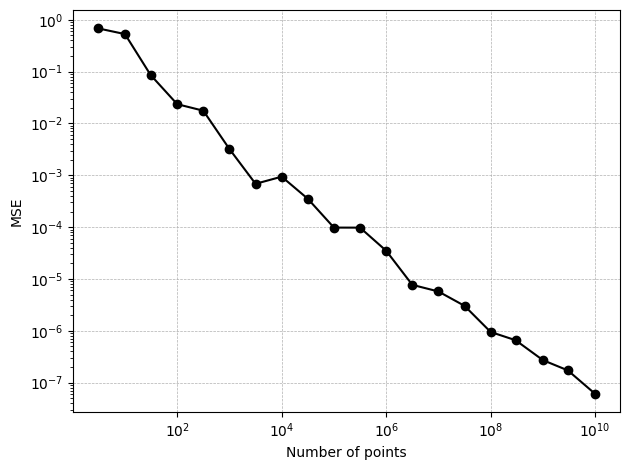

In [37]:
import matplotlib.pyplot as plt

plt.plot(list_N, err_N,  linestyle='-', marker='o', color='black')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of points")
plt.ylabel("MSE")

plt.grid(True, which='major', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig("1d-Sobolev.pdf")

## 1.4 Low-bias kernel (different values of s)

In [20]:
s_list = np.array([0.5+i/4 for i in range(40)])
train_lists = []

powers = np.arange(1, 9)
d = 1
n_samples = 10
threshold = 10e-10

N_test = 10**4
x_test = cp.random.uniform(size=N_test).astype(cp.float64)
y_test =  25*cp.abs(x_test-0.5).astype(cp.complex128)**3

for power in powers:
  print(power, "/", powers[-1])
  print("\n\n")

  N = 10**power
  training_error = np.array([])
  sob = np.array([])

  for s in s_list:
    lambda_n= N**(-(2*s)/(2*s+d))
    m = int(N**(1/(2*s+d)))

    S_inv = S_vect_inv(m, 0)

    mse_mean = 0

    for samples in range(n_samples):
      x_gpu =  cp.random.uniform(size=N).astype(cp.float64)
      y_gpu =  25*cp.abs(x_gpu-0.5).astype(cp.complex128)**3 + cp.random.normal(size=N).astype(cp.complex128)

      cov_y = S_inv*NUFFT_Y(x_gpu, y_gpu, m, threshold)
      hat_theta = FFT_inv(x_gpu, cov_y, m, 0, lambda_n, threshold, display=False)

      estimator = torch.real(NUFFT_inv(x_test, hat_theta, m, threshold))

      error = torch.real(estimator.cpu()) - torch.tensor(y_test.get(), dtype=torch.float64)
      mse = torch.mean(torch.square(torch.abs(error)))

      mse_mean +=mse
    mse_mean /=n_samples
    training_error = np.append(training_error, mse_mean)
  train_lists.append(training_error)

print("Done!")

1 / 8



2 / 8



3 / 8



4 / 8



5 / 8



6 / 8



7 / 8



8 / 8



Done!


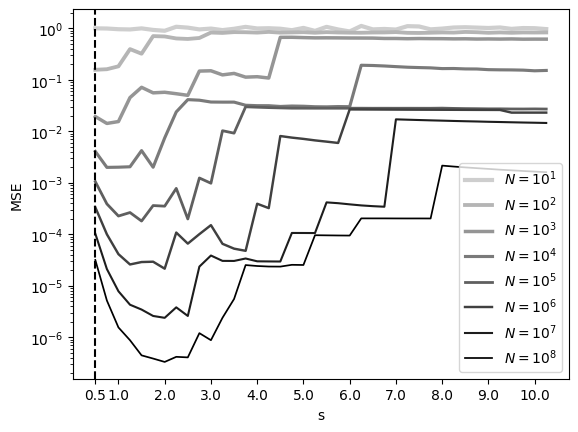

In [29]:
import matplotlib.pyplot as plt

colors = plt.cm.Greys(np.linspace(0.3, 1, len(powers)))

for i in range(len(powers)):
  plt.plot(s_list, train_lists[i], label = '$N = 10^'+str(powers[i])+'$',
           color = colors[i], linewidth= 3 - 0.25*i)
plt.xlabel("s")
plt.xticks(np.arange(0, 11, 1))
plt.ylabel("MSE")
plt.yscale('log')
plt.axvline(x=0.5, color="black",linestyle='--')

xticks = plt.xticks()[0]  # Get current x-tick locations
if 0.5 not in xticks:
    plt.xticks(list(xticks) + [0.5])  # Add 0.5 to the list

plt.legend()
plt.plot()
plt.savefig('low-bias.pdf')

## 1.5 Sobolev kernel (different values of s)

In [38]:
s_list = np.array([0.5+i/4 for i in range(40)])
train_lists = []

powers = np.arange(1, 9)
d = 1
n_samples = 10
threshold = 10e-10

N_test = 10**4
x_test = cp.random.uniform(size=N_test).astype(cp.float64)
y_test =  25*cp.abs(x_test-0.5).astype(cp.complex128)**3

for power in powers:
  print(power, "/", powers[-1])
  print("\n\n")

  N = 10**power
  training_error = np.array([])
  sob = np.array([])

  for s in s_list:
    mse_mean = 0
    for samples in range(n_samples):
      x_gpu =  cp.random.uniform(size=N).astype(cp.float64)
      y_gpu =  25*cp.abs(x_gpu-0.5).astype(cp.complex128)**3 + cp.random.normal(size=N).astype(cp.complex128)

      lambda_n= N**(-(2*s)/(2*s+d))
      m =  int(N**(1/(2*s+d)))

      S_inv = S_vect_inv(m, s)
      cov_y = S_inv*NUFFT_Y(x_gpu, y_gpu, m, threshold)
      hat_theta = FFT_inv(x_gpu, cov_y, m, s, lambda_n, threshold, display=False)

      estimator = torch.real(NUFFT_inv(x_test, hat_theta, m, threshold))

      error = torch.real(estimator.cpu()) - torch.tensor(y_test.get(), dtype=torch.float64)
      mse = torch.mean(torch.square(torch.abs(error)))
      mse_mean +=mse

    mse_mean /=n_samples

    training_error = np.append(training_error, mse_mean)
  train_lists.append(training_error)
print("Done!")

1 / 8



2 / 8



3 / 8



4 / 8



5 / 8



6 / 8



7 / 8



8 / 8



Done!


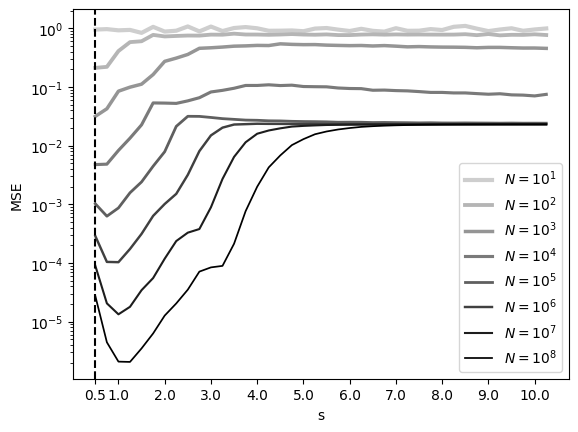

In [40]:
import matplotlib.pyplot as plt

colors = plt.cm.Greys(np.linspace(0.3, 1, len(powers)))

for i in range(len(powers)):
  plt.plot(s_list, train_lists[i], label = '$N = 10^'+str(powers[i])+'$',
           color = colors[i], linewidth= 3 - 0.25*i)
plt.yscale('log')
plt.xlabel("s")
plt.xticks(np.arange(0, 11, 1))
plt.ylabel("MSE")

plt.axvline(x=0.5, color="black",linestyle='--')
xticks = plt.xticks()[0]  # Get current x-tick locations
if 0.5 not in xticks:
    plt.xticks(list(xticks) + [0.5])  # Add 0.5 to the list

plt.legend()
plt.plot()
plt.savefig('1d-Sob.pdf')


# 2- Physics-informed kernel

In [41]:
def domain_FFT(m, device):
  freq =  torch.arange(0, 2*m+1, device=device)
  col = torch.where(
        freq == 0,
        1 / (2 * torch.pi),
        (torch.exp(1j * freq)-1) / (2 * torch.pi * 1j * freq)
    )
  return circulant_col(col, device)[0]

def PDE_vect(m):
  frequencies =  torch.arange(-m, m+1, device=device)
  return 1 + 1j*frequencies

def A_function_PIKL(x, lambda_n, mu, S_inv, PDE_vector, k_circ, explicit_FFT, FFT_circ):
  n = x.shape[0]

  kernel_term = S_inv* fast_hermitian_toeplitz_mv(k_circ, n, S_inv * x, device)

  if explicit_FFT:
    PDE_term = S_inv*torch.conj_physical(PDE_vector)* fast_hermitian_toeplitz_mv(FFT_circ, n, PDE_vector*S_inv * x, device)
    return kernel_term + lambda_n * x + mu * PDE_term
  else:
    PDE_term = S_inv*torch.conj_physical(PDE_vector)* fast_hermitian_toeplitz_mv(k_circ, n, PDE_vector*S_inv * x, device)
    return kernel_term + lambda_n * x + mu * PDE_term

def FFT_inv_PIKL(x_gpu, nufft, m, lambda_n, mu, threshold, explicit_FFT, display=True):
    k_vect = kernel_vect(x_gpu, 2*m+1, threshold)
    S_inv = S_vect_inv(m, s)
    PDE_vector = PDE_vect(m)

    if explicit_FFT:
      FFT_circ = domain_FFT(m, device)
    else:
      FFT_circ = None

    A_funct = lambda x: A_function_PIKL(x, lambda_n, mu, S_inv, PDE_vector, k_vect, explicit_FFT, FFT_circ)

    x0 = nufft.clone()
    inv = conjugate_gradient(A_funct,  nufft, x0, tol=threshold, display=display)
    print("Error CG ", torch.linalg.norm(A_funct(inv) - nufft))
    return S_inv * inv




In [42]:
import time
np.random.seed(42)
cp.random.seed(seed=1)
torch.manual_seed(1)

s,d = 1,1
threshold = 10**-6


for experiment in range(n_tries):
  print("Experiment = ", experiment)
  err_N_PIKL, list_N_PIKL, time_N_PIKL = np.array([]), np.array([]), np.array([])

  for i in range(1, 17):
    N = int(10**(i/2))

    x_gpu =  cp.random.uniform(size=N).astype(cp.float64)
    y_gpu =  cp.exp(x_gpu).astype(cp.complex128) + cp.random.normal(size=N).astype(cp.complex128)


    lambda_n=N**(-(2*s)/(2*s+d))
    mu = 1
    m = int(N**(1/(2*s+d)))
    explicit_FFT = False

    torch.cuda.synchronize()
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()

    S_inv = S_vect_inv(m, s)

    cov_y = S_inv*NUFFT_Y(x_gpu, y_gpu, m, threshold)
    hat_theta = FFT_inv_PIKL(x_gpu, cov_y, m, lambda_n, mu, threshold, explicit_FFT, display=False)

    end_event.record()
    torch.cuda.synchronize()
    time_N_PIKL = np.append(time_N_PIKL,start_event.elapsed_time(end_event)/10**3)


    N_test = 10**4
    x_test = cp.random.uniform(size=N_test).astype(cp.float64)
    y_test = cp.exp(x_test).astype(cp.complex128)

    estimator = torch.real(NUFFT_inv(x_test, hat_theta, m, threshold))
    error = torch.real(estimator.cpu()) - torch.tensor(y_test.get(), dtype=torch.float64)
    mse = torch.mean(torch.square(torch.abs(error)))

    list_N_PIKL = np.append(list_N_PIKL, N)
    err_N_PIKL = np.append(err_N_PIKL, mse)

  if experiment ==0:
    err_N_PIKL_mean = err_N_PIKL/n_tries
    time_N_PIKL_mean = time_N_PIKL/n_tries
  else:
    err_N_PIKL_mean += err_N_PIKL/n_tries
    time_N_PIKL_mean += time_N_PIKL/n_tries

Experiment =  0
Error CG  tensor(5.2311e-14, device='cuda:0')
Error CG  tensor(2.2405e-07, device='cuda:0')
Error CG  tensor(6.8619e-09, device='cuda:0')
Error CG  tensor(1.7090e-09, device='cuda:0')
Error CG  tensor(2.8785e-08, device='cuda:0')
Error CG  tensor(1.0148e-07, device='cuda:0')
Error CG  tensor(1.9532e-07, device='cuda:0')
Error CG  tensor(5.4913e-08, device='cuda:0')
Error CG  tensor(1.1075e-07, device='cuda:0')
Error CG  tensor(9.1826e-08, device='cuda:0')
Error CG  tensor(1.3776e-07, device='cuda:0')
Error CG  tensor(5.6526e-07, device='cuda:0')
Error CG  tensor(2.0649e-07, device='cuda:0')
Error CG  tensor(2.5784e-07, device='cuda:0')
Error CG  tensor(5.7945e-07, device='cuda:0')
Error CG  tensor(9.0991e-07, device='cuda:0')
Experiment =  1
Error CG  tensor(5.1925e-14, device='cuda:0')
Error CG  tensor(2.6853e-07, device='cuda:0')
Error CG  tensor(5.1195e-09, device='cuda:0')
Error CG  tensor(5.7279e-10, device='cuda:0')
Error CG  tensor(5.0143e-09, device='cuda:0')
Er

In [43]:
threshold = 10e-6
s,d = 1,1
display = False

for experiment in range(n_tries):
  print("Experiment = ", experiment)
  err_N_PIKL_exact, list_N_PIKL_exact, time_N_PIKL_exact = np.array([]), np.array([]), np.array([])

  for i in range(1, 17):
    N = int(10**(i/2))
    x_gpu =  cp.random.uniform(size=N).astype(cp.float64)
    y_gpu =  cp.exp(x_gpu).astype(cp.complex128) + cp.random.normal(size=N).astype(cp.complex128)


    lambda_n=N**(-(2*s)/(2*s+d))
    mu = 1
    m = int(N**(1/(2*s+d)))
    explicit_FFT = True

    torch.cuda.synchronize()
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()

    S_inv = S_vect_inv(m, s)

    cov_y = S_inv*NUFFT_Y(x_gpu, y_gpu, m, threshold)
    hat_theta = FFT_inv_PIKL(x_gpu, cov_y, m, lambda_n, mu, threshold, explicit_FFT, display)

    end_event.record()
    torch.cuda.synchronize()
    time_N_PIKL_exact = np.append(time_N_PIKL_exact,start_event.elapsed_time(end_event)/10**3)


    N_test = 10**4
    x_test = cp.random.uniform(size=N_test).astype(cp.float64)
    y_test = cp.exp(x_test).astype(cp.complex128)

    estimator = torch.real(NUFFT_inv(x_test, hat_theta, m, threshold))
    error = torch.real(estimator.cpu()) - torch.tensor(y_test.get(), dtype=torch.float64)
    mse = torch.mean(torch.square(torch.abs(error)))

    list_N_PIKL_exact = np.append(list_N_PIKL_exact, N)
    err_N_PIKL_exact = np.append(err_N_PIKL_exact, mse)

  if experiment ==0:
    err_N_PIKL_exact_mean = err_N_PIKL_exact/n_tries
    time_N_PIKL_exact_mean = time_N_PIKL_exact/n_tries
  else:
    err_N_PIKL_exact_mean += err_N_PIKL_exact/n_tries
    time_N_PIKL_exact_mean += time_N_PIKL_exact/n_tries

Experiment =  0
Error CG  tensor(3.4812e-15, device='cuda:0')
Error CG  tensor(9.2767e-08, device='cuda:0')
Error CG  tensor(1.2395e-09, device='cuda:0')
Error CG  tensor(6.9696e-07, device='cuda:0')
Error CG  tensor(1.5327e-07, device='cuda:0')
Error CG  tensor(1.7755e-08, device='cuda:0')
Error CG  tensor(4.8072e-06, device='cuda:0')
Error CG  tensor(9.7381e-07, device='cuda:0')
Error CG  tensor(1.6235e-07, device='cuda:0')
Error CG  tensor(1.4595e-06, device='cuda:0')
Error CG  tensor(4.7946e-06, device='cuda:0')
Error CG  tensor(5.8621e-06, device='cuda:0')
Error CG  tensor(1.1152e-06, device='cuda:0')
Error CG  tensor(2.3203e-06, device='cuda:0')
Error CG  tensor(5.1290e-06, device='cuda:0')
Error CG  tensor(8.6055e-06, device='cuda:0')
Experiment =  1
Error CG  tensor(8.9030e-15, device='cuda:0')
Error CG  tensor(1.5037e-08, device='cuda:0')
Error CG  tensor(5.2875e-06, device='cuda:0')
Error CG  tensor(2.3135e-07, device='cuda:0')
Error CG  tensor(7.0701e-07, device='cuda:0')
Er

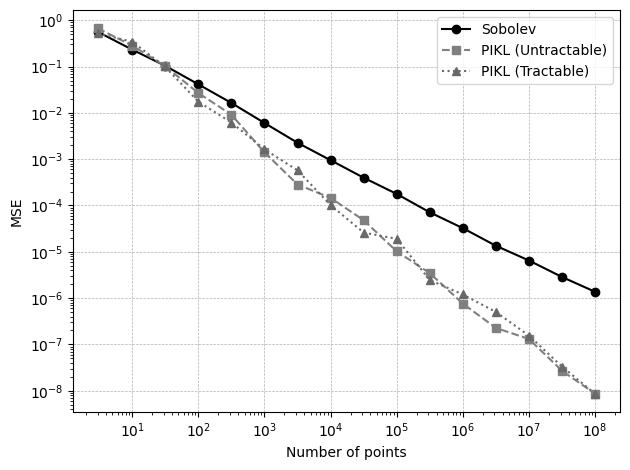

In [46]:
import matplotlib.pyplot as plt

plt.plot(list_N[:16], err_N_mean[:16], label="Sobolev", linestyle='-', marker='o', color='black')
plt.plot(list_N_PIKL, err_N_PIKL_mean, label="PIKL (Untractable)", linestyle='--', marker='s', color='gray')
plt.plot(list_N_PIKL_exact, err_N_PIKL_exact_mean, label="PIKL (Tractable)", linestyle=':', marker='^', color='dimgray')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of points")
plt.ylabel("MSE")
plt.legend()
plt.grid(True, which="major", ls="--", linewidth=0.5)
plt.tight_layout()

plt.savefig("PIKL_perf.pdf")
plt.show()


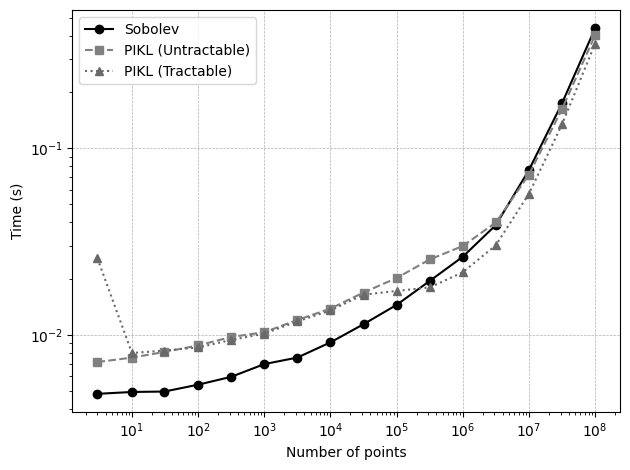

In [47]:
import matplotlib.pyplot as plt


plt.plot(list_N[:16], time_N_mean[:16], label="Sobolev", linestyle='-', marker='o', color='black')
plt.plot(list_N_PIKL, time_N_PIKL_mean, label="PIKL (Untractable)", linestyle='--', marker='s', color='gray')
plt.plot(list_N_PIKL_exact, time_N_PIKL_exact_mean, label="PIKL (Tractable)", linestyle=':', marker='^', color='dimgray')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of points")
plt.ylabel("Time (s)")

# Grid only on major ticks (10^n)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("PIKL_time.pdf")